# Multi-Signal Alpha Strategy

By Ankit Nakhawa, Parth Kocheta, Rajat Baldawa (Fall 2023)

This strategy was made for the Smith Investment Fund 2023 Alpha Competition.


### Package Imports
Below are the following packages that were used in our project. Along with numpy, pandas, and matplotlib for data management, financial data was imported with internal sif tools along with trading strategies accessed via pandas_ta.

In [ ]:
import logging
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sif.siftools.backtesters import full_backtesters as fb
from sif.siftools.abstractalpha import AbstractAlpha
from sif.siftools import operators as op
from sif.siftools import metrics
from IPython.core import display as ICD
%pip install pandas_ta
import pandas_ta as ta

plt.rcParams['figure.figsize'] = (15, 9)

In [2]:
show_logs = False # Set this to False if you do not want the logs to be shown
logger = None
if show_logs:
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

In [ ]:
backtester = fb.FullSingleBacktester(
    start_date=datetime.datetime(year=2010, month=1, day=1),
    end_date=datetime.datetime(year=2015, month=12, day=31),
    universe_rebalance_dates=[(1, 1), (4, 1), (7, 1), (10, 1)],
    max_lookback=252,
    universe_size=500,
    factors=['open', 'high', 'low', 'close', 'volume']
)

# Uncomment to save backtester for later usage
backtester.save_local('full_demo_data.npy')

# Alternatively, if you have previously saved the backtester, uncomment the
# code below and insert the path to the '.npy' file it is saved as

# backtester = fb.FullSingleBacktester.from_local('full_demo_data.npy')

## Stochastic Averages Strategy

### Strategy Overview 

The Stochastic Averages strategy makes use of three different signals:
* Stochastic Oscillator (via pandas_ta)
* Simple Moving Average (SMA)
* Expected Moving Average (EMA)

The buy and sell signals are determined based on whether the stochastic oscillator reaches a certain percentage value (*see below for detailed explanation of stochastic oscillator*).

Each buy and sell signal is then weighted based on the SMA and EMA, such that stocks are only bought if the EMA is less than the SMA to find stocks with the most potential for gains.



### Stochastic Oscillator

The Stochastic Oscillator is designed to detect when a given stock is overbought or oversold (when closing values continue on an upward trend, they have exceeded the normal intrinsic stock value, or vice versa). 

Stochastic Oscillator formula: 

$$ \%K = \frac{{\text{{Current Close}} - \text{{Lowest Low}}}}{{\text{{Highest High}} - \text{{Lowest Low}}}} $$

Note: The lowest low and highest high are within a certain specified time period, which is usually 14 days.

The idea behind our implmentation of stochastic oscillator was to observe %K at smaller values. Most stocks in our universe size did not exceed 60% for the sample data, however we still created buy signals as stocks began to become oversold, and sell signals as they became overbought.



### SMA and EMA

Using Stochastic Oscillator alone provides a shortcoming: if we bought and sold when K% was 50% or 55% respectively, the trends in the stock are likely to continue in many cases. 

Because of this, we implemented two other momentum (SMA and EMA) strategies to weigh the buy and sell signals. 

SMA is a basic calculation of average price of an asset over a certain time period. This allows for simple trend observation to be supplemented with the Stochastic Oscillator.

Simple Moving Average is calculated as follows:

$$
SMA = \frac{\text{Closing price sum}}{N \text{(time period)}}
$$

Exponential Moving Average is calculated as follows: 

$$
EMA_{\text{current}} = \epsilon \cdot (\text{Current Price} - EMA_{\text{prev}}) + EMA_{\text{current}}
$$

$$
\epsilon = \text{smoothing factor calculated by } (2)/(1+N) \\
\text{Current Price = current price of the asset} \\
EMA_{\text{prev}} = \text{Previously calculated EMA} \\
EMA_{\text{current}} = \text{Current EMA being calculated} \\
$$


EMA puts more emphasis on the most current periods value. Because of this, we compare EMA and SMA such that the signal is only weighed as a buy if EMA > SMA, in other words, if the position has potential for short term change. This goes well with stochastic since we are using stochastic oscillators in less extremem parameters of K%, allowing our trading strategy to capitalize on short term trades.

In [40]:
%pip install pandas_ta
import pandas_ta as ta
import numpy as np

class StochasticAverages(AbstractAlpha):
    def __init__(self):
        super(StochasticAverages, self).__init__()
        self.name = 'Stochastic Averages'
        self.factor_list = ['open', 'high', 'low', 'close']  # Include all needed factors
        self.lookback = 30  # Adjust based on the longest period required by the indicators
        self.universe_size = 500  # Total universe size
    def generate_day(self, day, data):
        weights = np.zeros(self.universe_size)
        for i in range(self.universe_size):
            # Check if the stock index is within bounds
            df = data['close']
            if i >= df.shape[0]:
                continue
            # Extracting price data for each stock
            # open_prices = pd.Series(data['open'][i, :])
            high_prices = pd.Series(data['high'][i, :])
            low_prices = pd.Series(data['low'][i, :])
            close_prices = pd.Series(data['close'][i, :])
            stochastic = ta.stoch(high=high_prices, low=low_prices, close=close_prices, k=14, d=3) if len(close_prices) >= 14 else None
            if stochastic is None:
                continue

            sma = df[i].sum() /(self.lookback + 1)
            ema = df[i][0]
            smoothing = 2 / (self.lookback + 2)
            for j in range(1, self.lookback):
                ema = smoothing * df[i][j] + (1 - smoothing) * ema

            # Trading signals based on MACD, RSI, and Stochastic
            buy_signal = (stochastic['STOCHk_14_3_3'].iloc[-1] < 50)
            sell_signal = (stochastic['STOCHk_14_3_3'].iloc[-1] > 55)

            # Only buy if EMA < SMA to find stocks with most potential for gain
            if buy_signal:
                weights[i] = max(0, sma - ema)
            elif sell_signal:
                weights[i] = -1
        # Normalize weights across the universe
        total_weight = np.sum(np.abs(weights))
        if total_weight > 0:
            weights /= total_weight
        return weights

Note: you may need to restart the kernel to use updated packages.


In [41]:
returns, holdings = backtester.backtest(StochasticAverages(), use_env_universe=False)

/Users/ankitnakhawa/sif/sif/siftools/backtesters/full_backtesters.py:362: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  returns = pd.Series(index=self.trading_days)
2015-12-31 00:00:00: 100%|██████████| 1510/1510 [01:11<00:00, 21.18it/s]


0.3770041479042474


<AxesSubplot:>

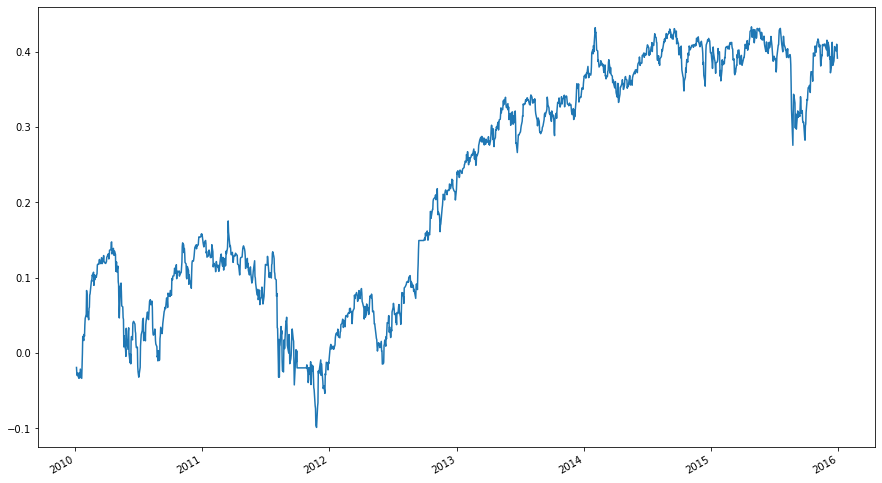

In [42]:
total_return = np.prod(1 + returns) - 1
print(total_return)
returns.cumsum().plot()

In [45]:
# Assuming returns and holdings are defined earlier in your code
perf_tables = metrics.generate_performance_table(returns, holdings)
ICD.display(perf_tables)


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2010,0.157638,0.878668,1.249080,0.170251,0.143229,26.253968,2.456349
2011,-0.171815,-0.826551,-1.052395,0.252969,0.035925,20.190476,7.626984
2012,0.231256,1.864692,3.030455,0.096682,0.449717,21.404000,0.000000
2013,0.140653,1.218742,1.699133,0.071920,0.268473,24.841270,1.571429
2014,0.040992,0.364926,0.565952,0.095651,0.005088,24.496032,7.480159
2015,-0.007326,-0.045934,-0.067937,0.148721,0.006672,32.000000,0.000000
Overall,0.391398,0.423290,0.575132,0.252969,0.160014,24.868874,3.193377


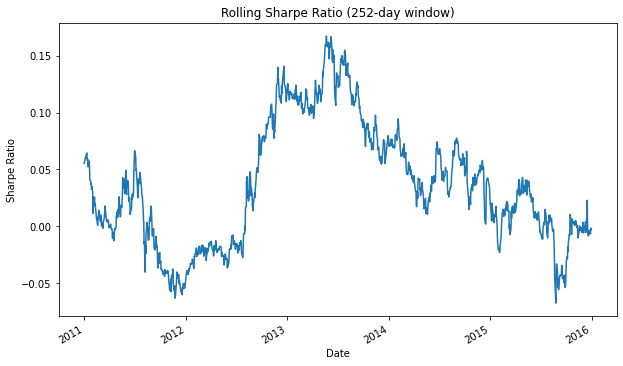

In [46]:
rolling_sharpe_ratio = returns.rolling(window=252).mean() / returns.rolling(window=252).std()
plt.figure(figsize=(10, 6))
rolling_sharpe_ratio.plot()
plt.title('Rolling Sharpe Ratio (252-day window)')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.show()